In [68]:
import numpy as np
import pandas as pd
import plotly 

import matplotlib.pyplot as plt
import matplotlib as mpl

from opentisim import hydrogen_objects
from opentisim import hydrogen_defaults
from opentisim import hydrogen_system

# plotly.tools.set_credentials_file(username='stephh', api_key='aYheUBjQH0kyWL5yo9E6')

# 0. Prepare inputs

In [69]:
startyear = 2019
lifecycle = 10

## 0.1 Generate demand forecast scenario

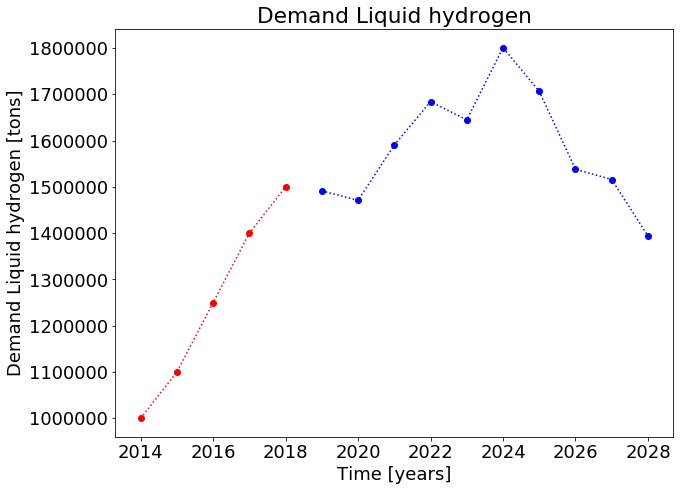

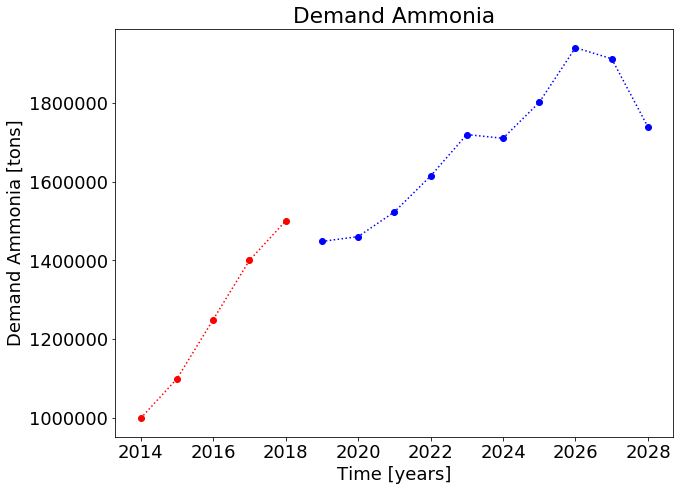

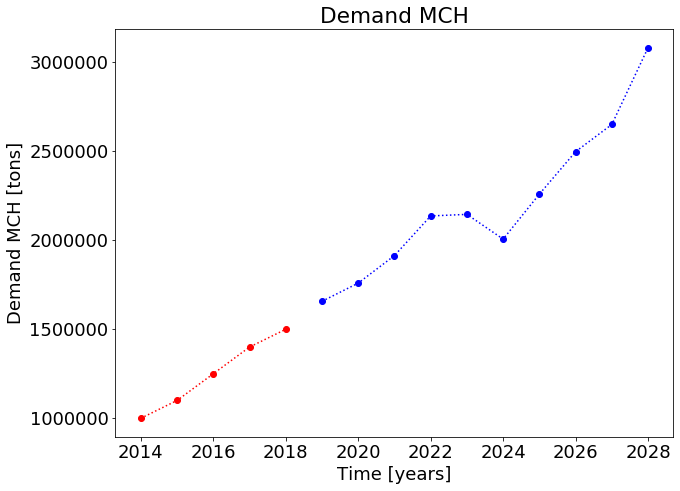

In [70]:
scenario = 'random' #choice between permanent or random

if scenario == 'random': 
    # instantiate a commodity object
    lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)
    ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_ammonia_data)
    MCH = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_MCH_data)

    # create a future througput scenario
    lhydrogen.scenario_random(startyear = startyear, lifecycle = lifecycle)
    ammonia.scenario_random(startyear = startyear, lifecycle = lifecycle)
    MCH.scenario_random(startyear = startyear, lifecycle = lifecycle)

    demand = [ammonia]

    # plot scenarios 
    if True:
        lhydrogen.plot_demand()
        ammonia.plot_demand()
        MCH.plot_demand()
else: 
    years = list(range(startyear, startyear+lifecycle))

    demand = []
    for year in years: 
        if year < 2024: 
            demand.append(100000)
        else: 
            demand.append(300000)

    scenario_data={'year': years, 'volume': demand}

    # instantiate a commodity objects
    lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)
    lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

    # Ammonia
    hydrogen_defaults.commodity_ammonia_data['historic_data'] = []
    hydrogen_defaults.commodity_ammonia_data['scenario_data'] = []
    ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_ammonia_data)

    # MCH
    hydrogen_defaults.commodity_MCH_data['historic_data'] = []
    hydrogen_defaults.commodity_MCH_data['scenario_data'] = []
    MCH = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_MCH_data)

    # combine
    demand = [lhydrogen, ammonia, MCH]

    # plot scenarios 
    if False:
        lhydrogen.plot_demand()
        ammonia.plot_demand()
        MCH.plot_demand()

## 0.2 Generate vessels

In [71]:
# instantiate vessels
Smallhydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.smallhydrogen_data)
Largehydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.largehydrogen_data)
Smallammonia = hydrogen_objects.Vessel(**hydrogen_defaults.smallammonia_data)
Largeammonia = hydrogen_objects.Vessel(**hydrogen_defaults.largeammonia_data)
Handysize = hydrogen_objects.Vessel(**hydrogen_defaults.handysize_data)
Panamax = hydrogen_objects.Vessel(**hydrogen_defaults.panamax_data)
VLCC = hydrogen_objects.Vessel(**hydrogen_defaults.vlcc_data)


vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

# 1. Instantiate terminal system

In [72]:
Terminal = hydrogen_system.System(startyear = startyear, 
                         lifecycle = lifecycle, 
                         elements = demand + vessels, 
                         operational_hours = 5840,   # example Wijnand
                         debug=False)

   year   volume
0  2019  1448198
1  2020  1460418
2  2021  1522812
3  2022  1613837
4  2023  1718994
5  2024  1709681
6  2025  1800610
7  2026  1939408
8  2027  1911065
9  2028  1738323


60

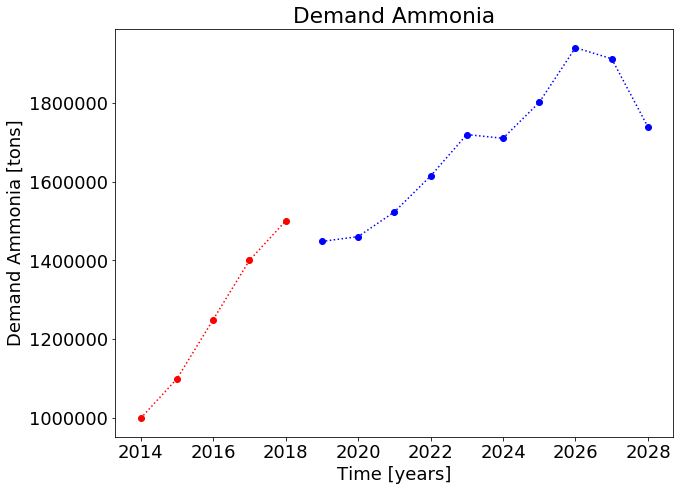

In [73]:
print(Terminal.elements[0].scenario_data)
Terminal.elements[0].plot_demand()
Terminal.elements[0].largeammonia_perc

In [74]:
Terminal.elements[0].__dict__

{'historic_data':    year   volume
 0  2014  1000000
 1  2015  1100000
 2  2016  1250000
 3  2017  1400000
 4  2018  1500000, 'scenario_data':    year   volume
 0  2019  1448198
 1  2020  1460418
 2  2021  1522812
 3  2022  1613837
 4  2023  1718994
 5  2024  1709681
 6  2025  1800610
 7  2026  1939408
 8  2027  1911065
 9  2028  1738323, 'type': 'Ammonia', 'handling_fee': 150, 'smallhydrogen_perc': 0, 'largehydrogen_perc': 0, 'smallammonia_perc': 40, 'largeammonia_perc': 60, 'handysize_perc': 0, 'panamax_perc': 0, 'vlcc_perc': 0, 'name': 'Ammonia', 'id': '591537df-2ee0-11ea-be63-60f677ba2ce0'}

# 2. Start simulation
Develop terminal given the throughput scenario and investment triggers implemented

In [75]:
Terminal.simulate()

PV: [-3.03276000e+08 -4.67068841e+08 -5.10920093e+08 -5.31900545e+08
 -5.08828414e+08 -4.27588452e+08 -4.07173376e+08 -4.23944027e+08
 -3.72033908e+08  1.20172657e+07]
NPV: -3940716390.051008


## Report all elements

In [76]:
if False: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__)

In [77]:
# Terminal.add_cashflow_elements()

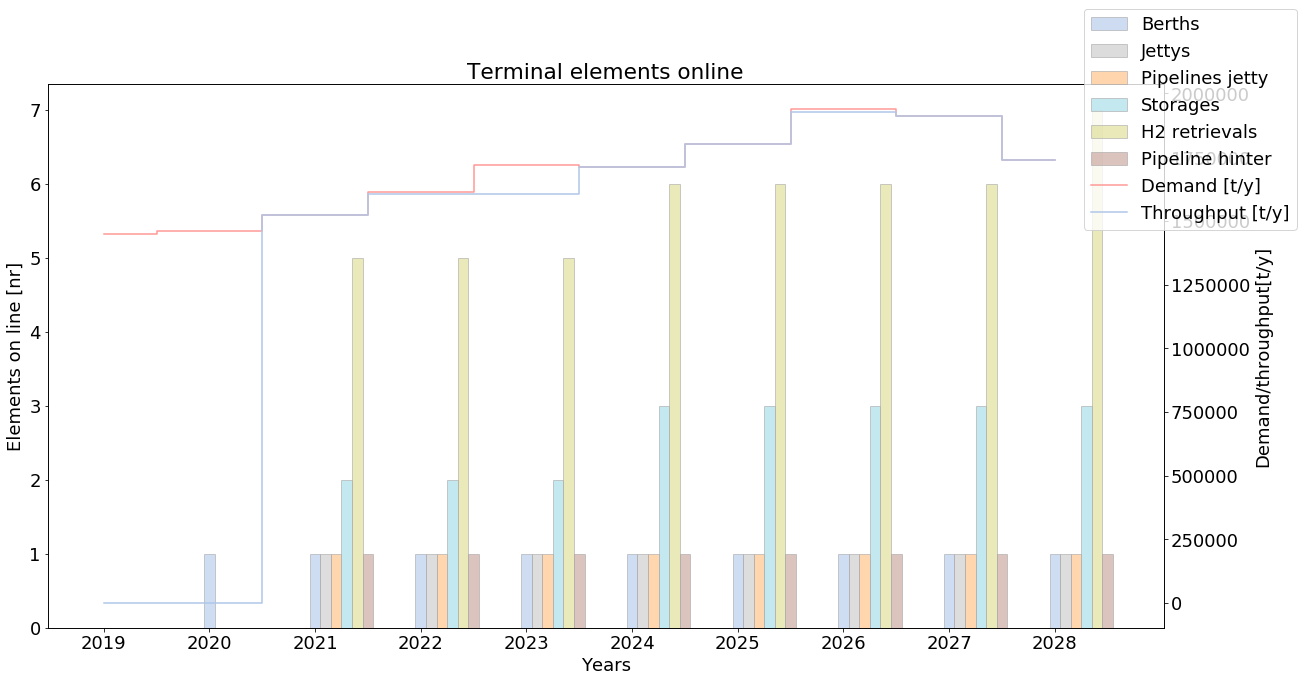

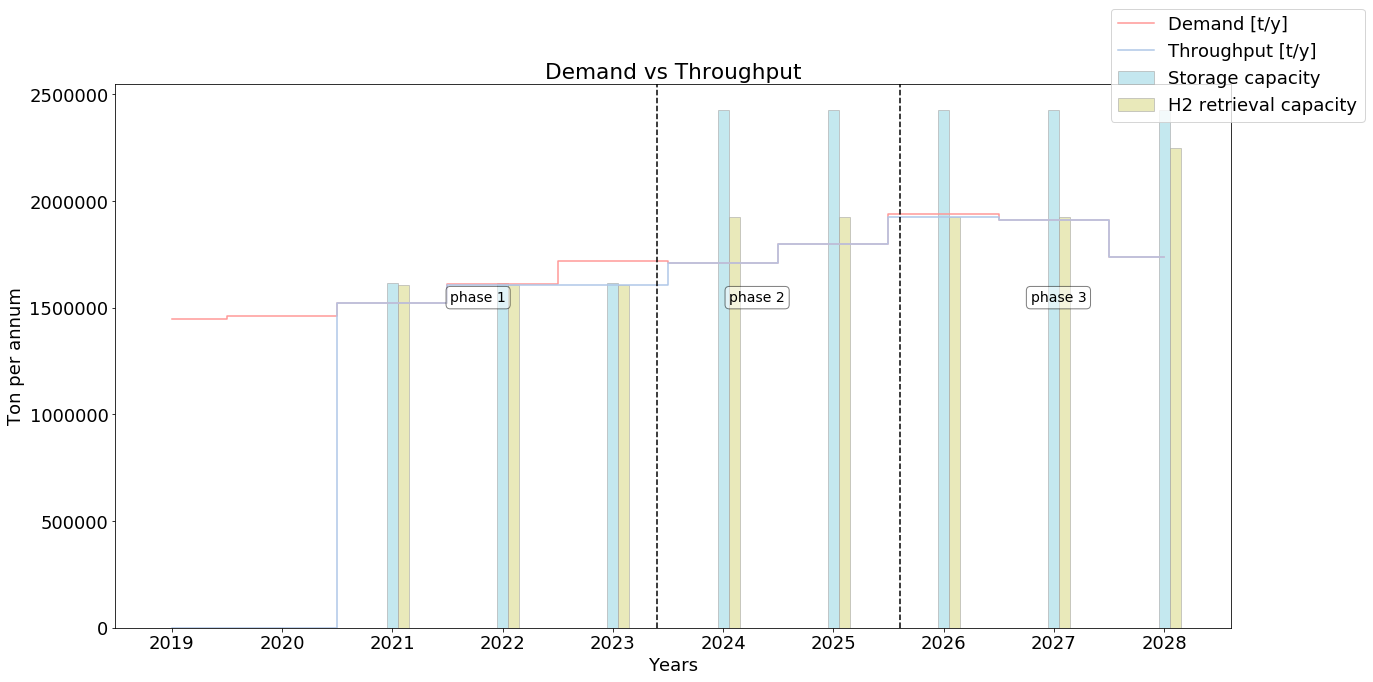

In [78]:
Terminal.terminal_elements_plot()
Terminal.demand_terminal_plot()

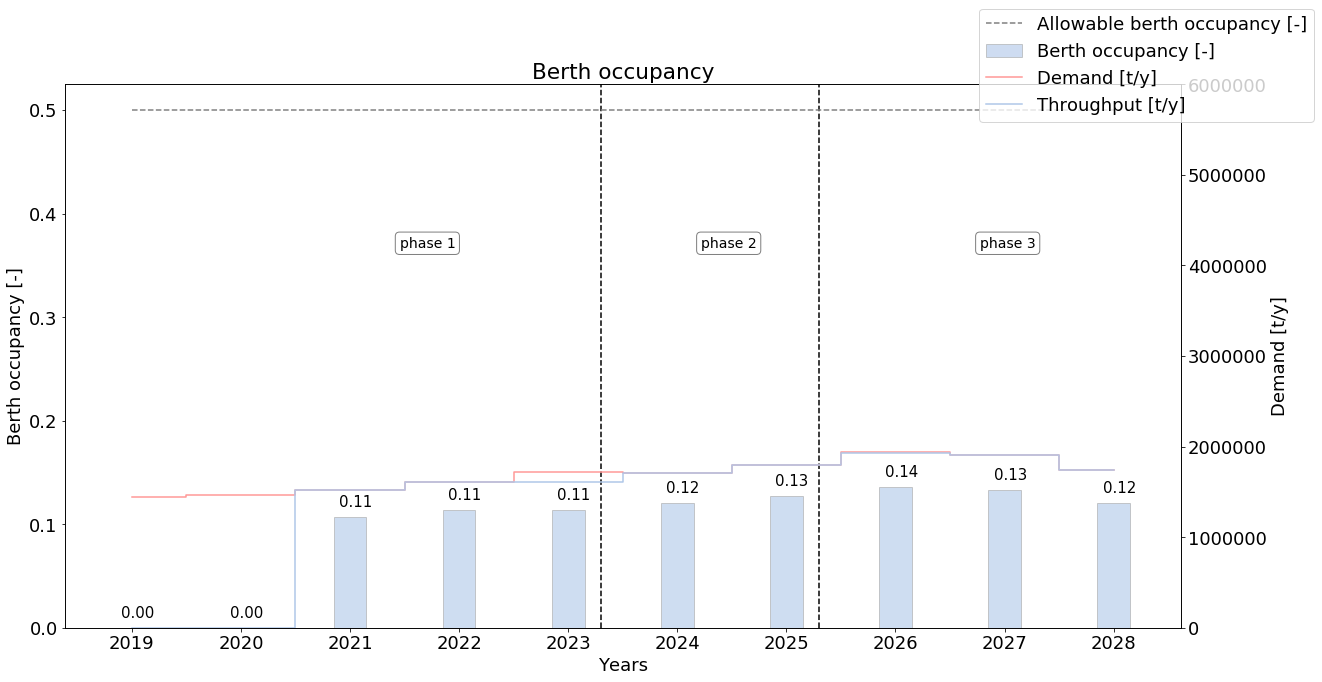

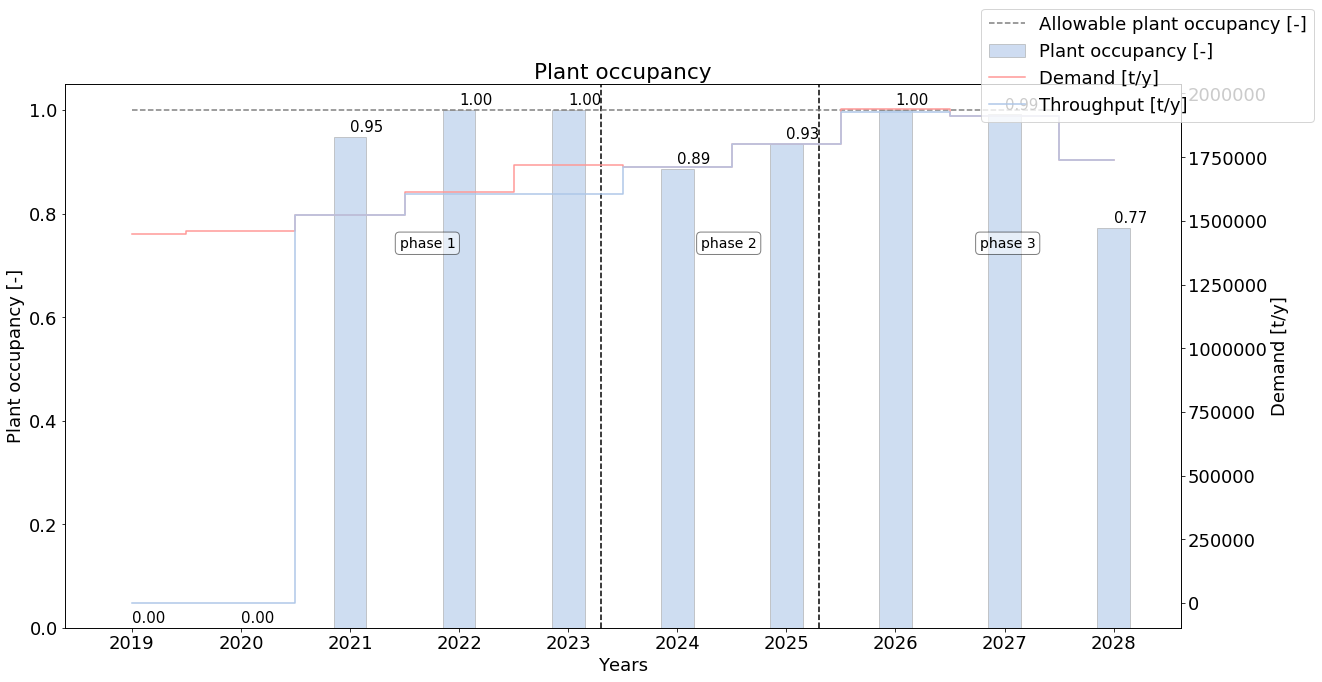

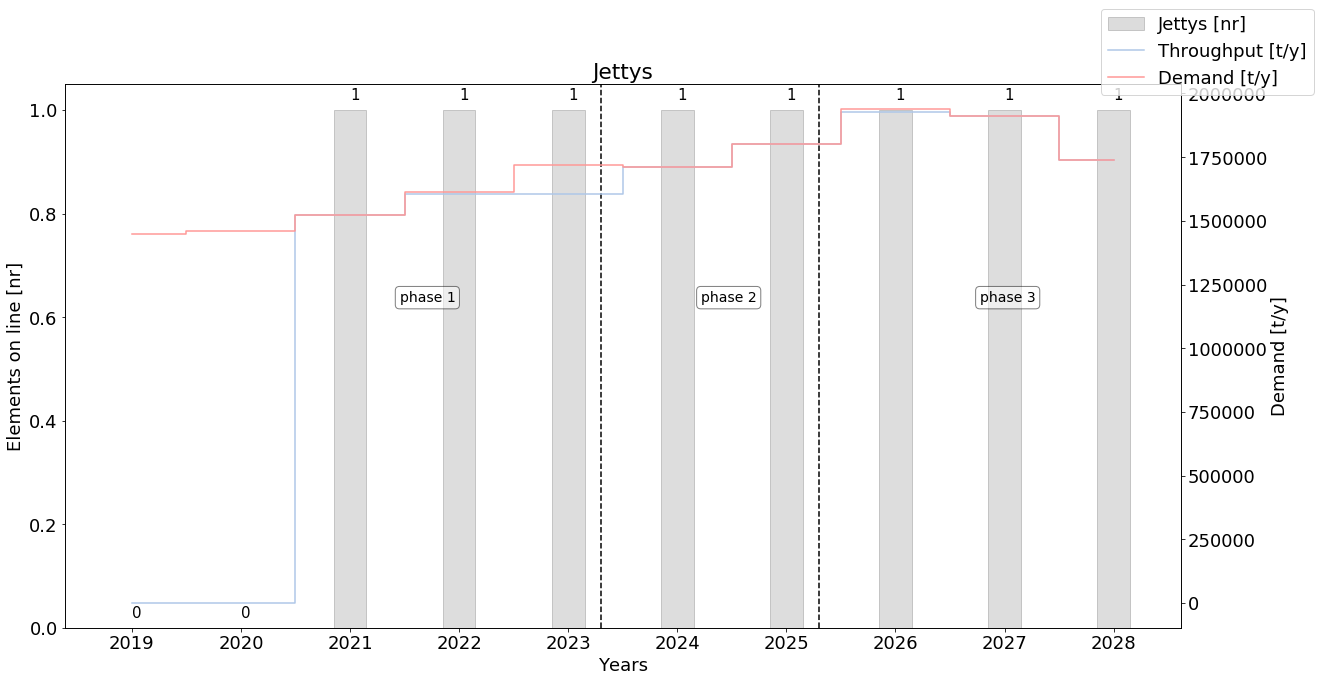

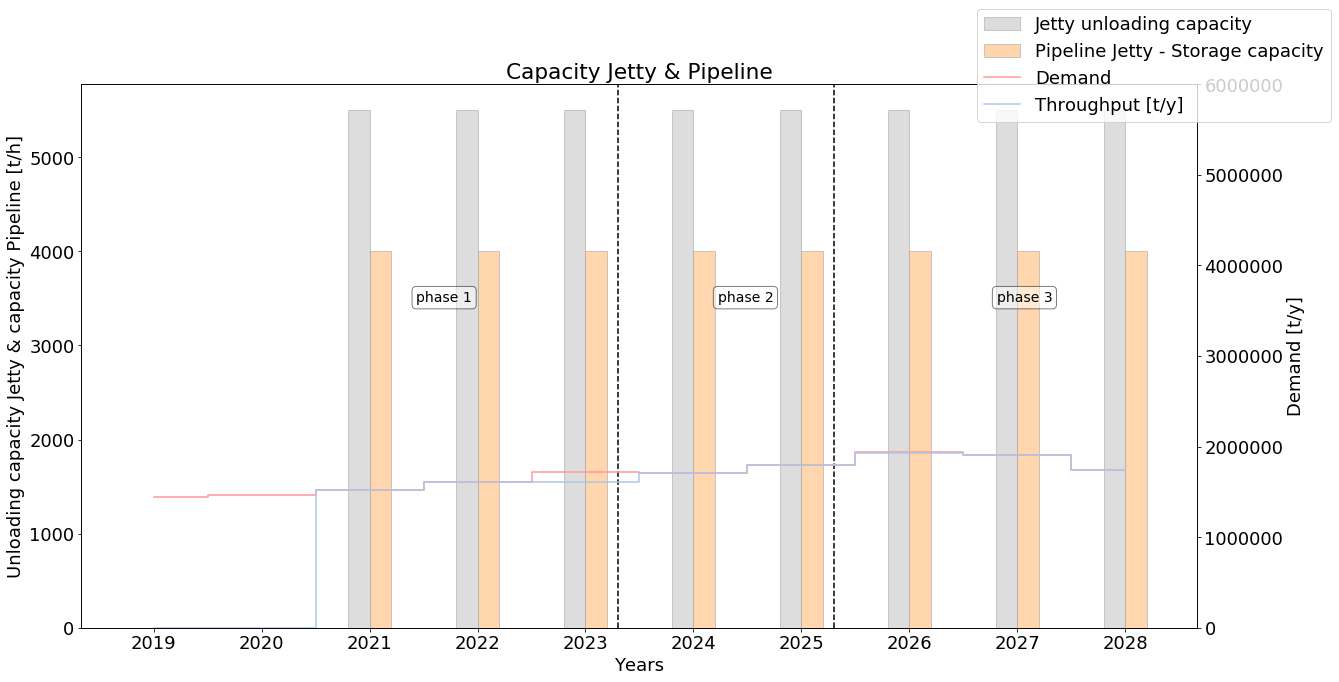

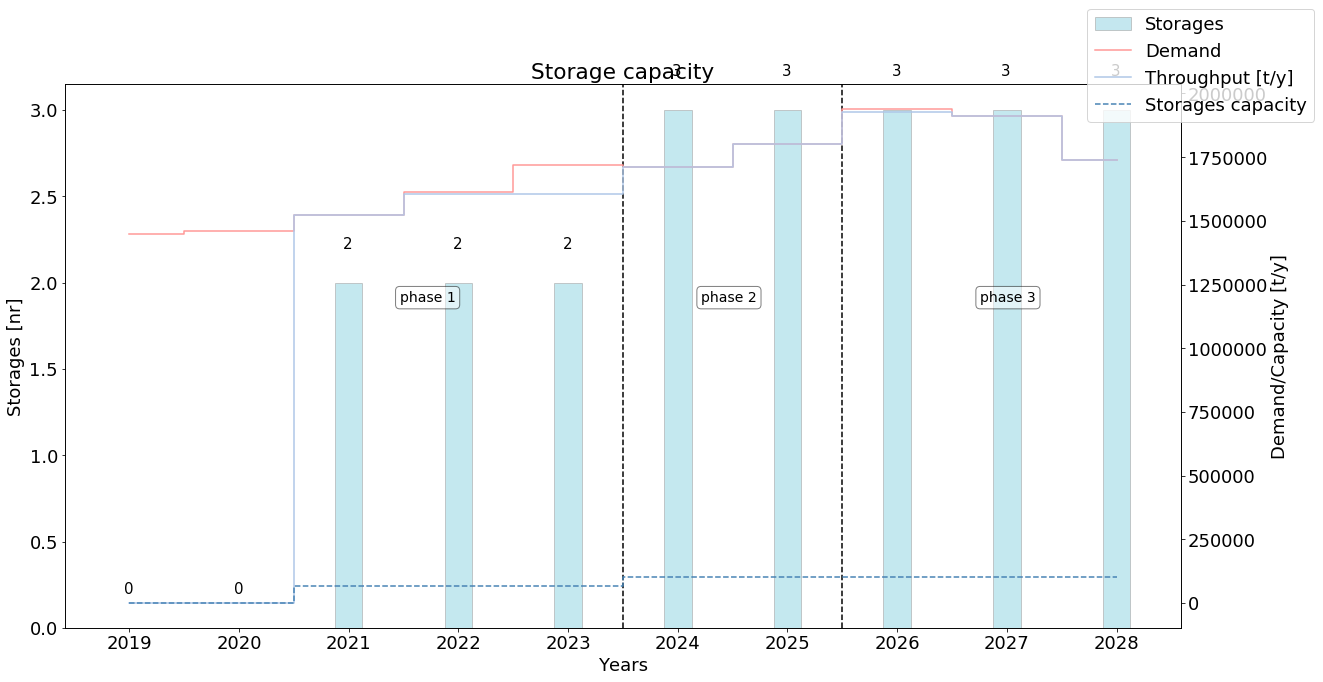

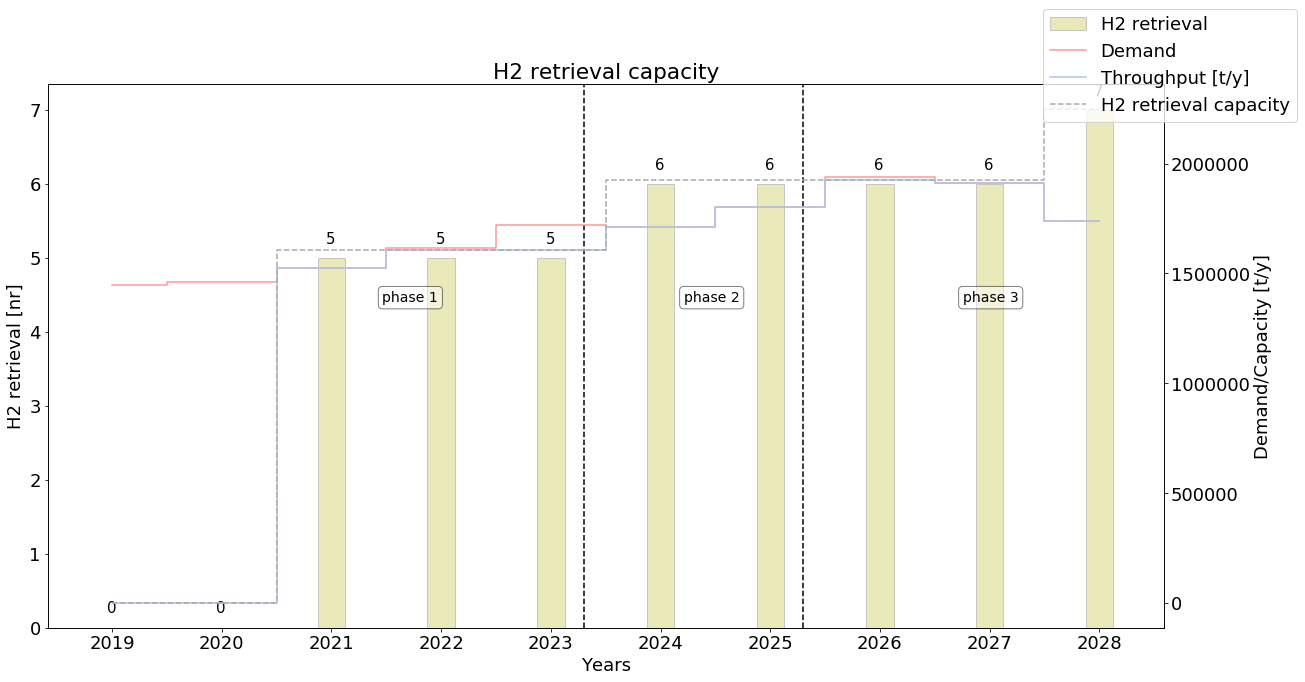

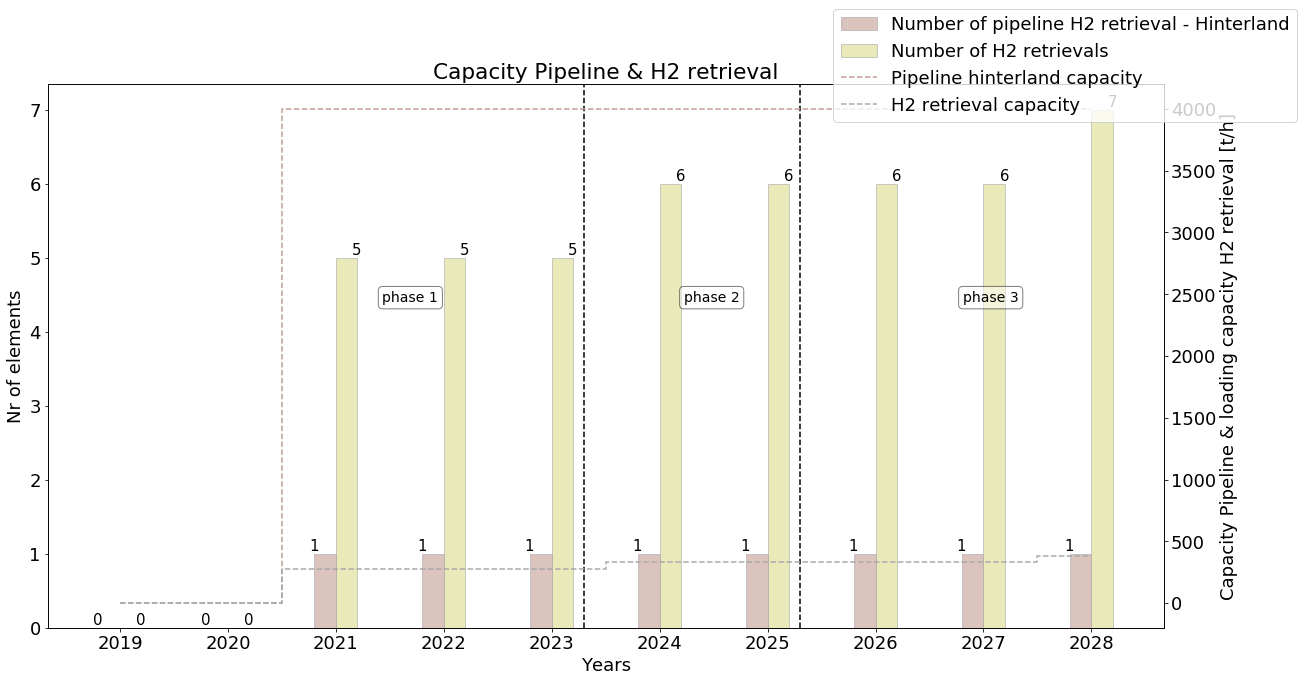

In [79]:
if True: 
    # to plot the terminal occupany's 
    Terminal.terminal_occupancy_plot() #occupancy of the berth 
    Terminal.plant_occupancy_plot() #occupancy of the plant
    
    # to plot the capacities of the different elements 
    Terminal.Jetty_capacity_plot() #jetty
    Terminal.Pipeline1_capacity_plot() #pipeline from jetty to storage
    Terminal.Storage_capacity_plot() #storage
    Terminal.H2retrieval_capacity_plot() # H2 retrieval
    Terminal.Pipeline2_capacity_plot() #pipeline from H2 retrieval to hinterland        

In [80]:
# add cash flow information for each of the Terminal elements
cash_flows, cash_flows_WACC_real = Terminal.add_cashflow_elements()

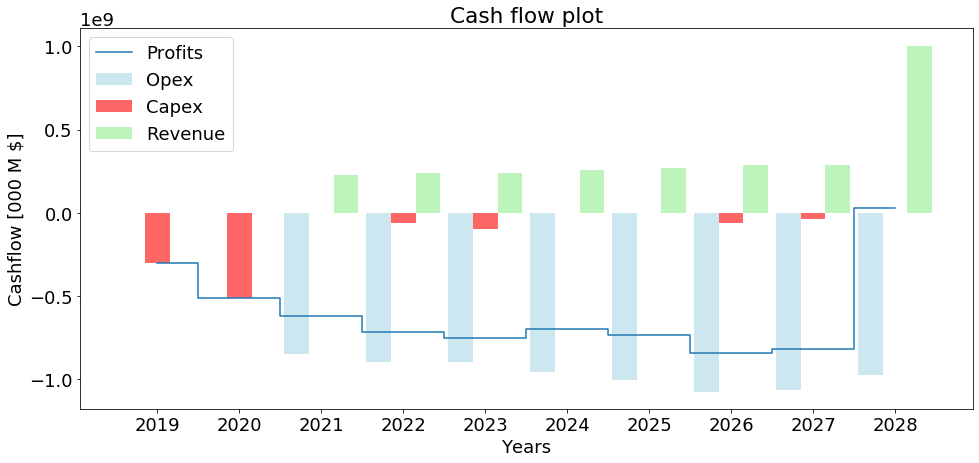

In [81]:
Terminal.cashflow_plot(cash_flows)

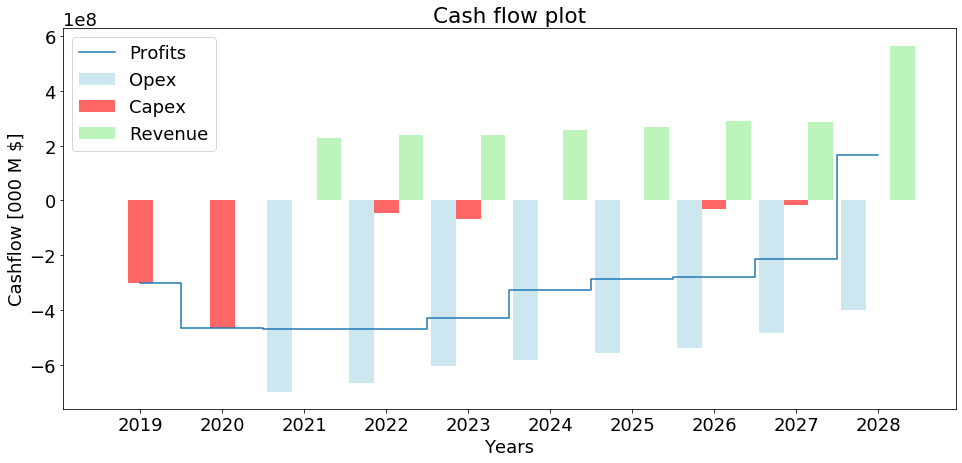

In [82]:
Terminal.cashflow_plot(cash_flows_WACC_real)